In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Dataset_Final.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Dataset_Final.zip')
f.keys()
!unzip Dataset_Final.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Final/train/08/390.jpg  
  inflating: Dataset_Final/train/08/391.jpg  
  inflating: Dataset_Final/train/08/392.jpg  
  inflating: Dataset_Final/train/08/393.jpg  
  inflating: Dataset_Final/train/08/395.jpg  
  inflating: Dataset_Final/train/08/396.jpg  
  inflating: Dataset_Final/train/08/397.jpg  
  inflating: Dataset_Final/train/08/399.jpg  
  inflating: Dataset_Final/train/08/4.jpg  
  inflating: Dataset_Final/train/08/40.jpg  
  inflating: Dataset_Final/train/08/400.jpg  
  inflating: Dataset_Final/train/08/401.jpg  
  inflating: Dataset_Final/train/08/402.jpg  
  inflating: Dataset_Final/train/08/403.jpg  
  inflating: Dataset_Final/train/08/404.jpg  
  inflating: Dataset_Final/train/08/405.jpg  
  inflating: Dataset_Final/train/08/406.jpg  
  inflating: Dataset_Final/train/08/408.jpg  
  inflating: Dataset_Final/train/08/409.jpg  
  inflating: Dataset_Final/train/08/41.jpg  
  inflating: Dataset_Final/train/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.17.0


In [ ]:
train_dir = '/content/Dataset_Final/train'
validation_dir = '/content/Dataset_Final/validation'
test_dir = '/content/Dataset_Final/test'



BATCH_SIZE = 32
IMG_SIZE = (96, 96)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE,
#                                                                  validation_split=.20,
#                                                                  subset='training',
#                                                                  seed=66)
# validation_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE,
#                                                                  validation_split=.20,
#                                                                  subset='validation',
#                                                                  seed=66)

Found 6744 files belonging to 19 classes.
Found 1348 files belonging to 19 classes.
Found 900 files belonging to 19 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),

    ]
)

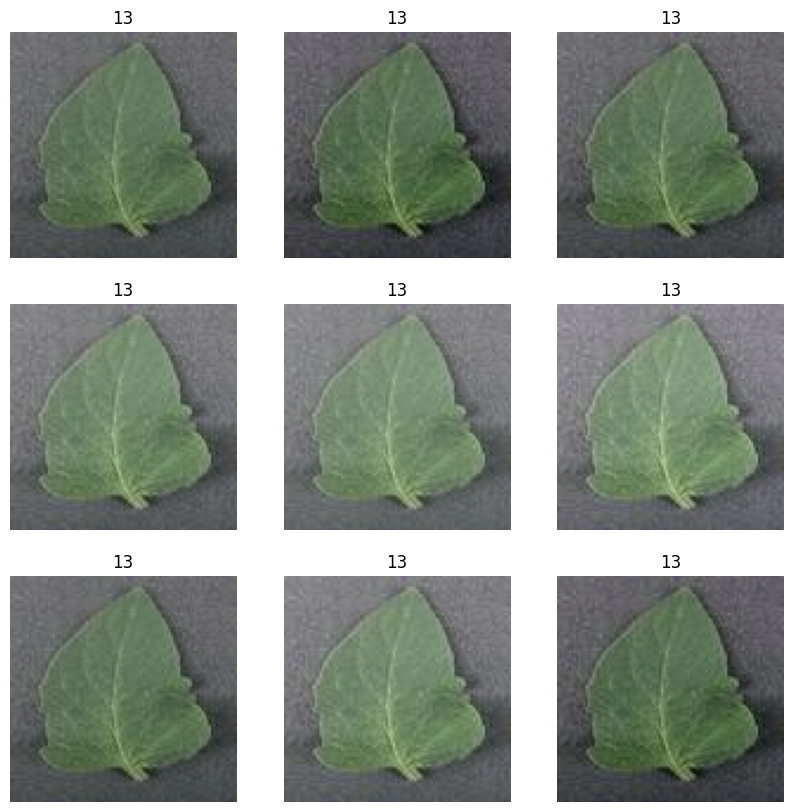

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
nb_classes = 19
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           9,747 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,296,787 (77.43 MB)

 Trainable params: 272,403 (1.04 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)


In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:

# Fit the model with both callbacks
epochs = 100
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.3833 - loss: 1.9274 - val_accuracy: 0.6736 - val_loss: 0.9083 - learning_rate: 0.0010
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6734 - loss: 0.9187 - val_accuracy: 0.7174 - val_loss: 0.7909 - learning_rate: 0.0010
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.7254 - loss: 0.7873 - val_accuracy: 0.7463 - val_loss: 0.6698 - learning_rate: 0.0010
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7340 - loss: 0.7206 - val_accuracy: 0.7552 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7577 - loss: 0.6712 - val_accuracy: 0.7671 - val_loss: 0.6232 - learning_rate: 0.0010
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.7628 - loss: 0.6577 - val_accuracy: 0.7834 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7650 

In [ ]:
scores = model.evaluate(test_dataset)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8811 - loss: 0.3333


In [ ]:
base_model.trainable = True
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           9,747 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,841,595 (79.50 MB)

 Trainable params: 20,296,787 (77.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 544,808 (2.08 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:

# Fit the model with both callbacks
epochs = 100
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 58s 197ms/step - accuracy: 0.8660 - loss: 0.3553 - val_accuracy: 0.8858 - val_loss: 0.3525 - learning_rate: 1.0000e-05
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 59s 146ms/step - accuracy: 0.9126 - loss: 0.2327 - val_accuracy: 0.8895 - val_loss: 0.3375 - learning_rate: 1.0000e-05
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.9404 - loss: 0.1619 - val_accuracy: 0.8932 - val_loss: 0.2961 - learning_rate: 1.0000e-05
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9517 - loss: 0.1363 - val_accuracy: 0.9228 - val_loss: 0.2246 - learning_rate: 1.0000e-05
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9664 - loss: 0.0872 - val_accuracy: 0.9184 - val_loss: 0.2471 - learning_rate: 1.0000e-05
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - accuracy: 0.9630 - loss: 0.0974 - val_accuracy: 0.9169 - val_loss: 0.2326 - learning_rate: 1.0000e-05
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpfne8ea6d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_25')
Output Type:
  TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)
Captures:
  138479920393808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479920397328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880152768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880149600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880245616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880248608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880248960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880251248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880252832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880256176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138479880256

In [ ]:
scores = model.evaluate(test_dataset)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9531 - loss: 0.1705


In [ ]:
scores = model.evaluate(train_dataset)

211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9996 - loss: 0.0024


In [ ]:
scores = model.evaluate(validation_dataset)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9304 - loss: 0.2256


In [ ]:
class_names = test_dataset.class_names
class_names

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


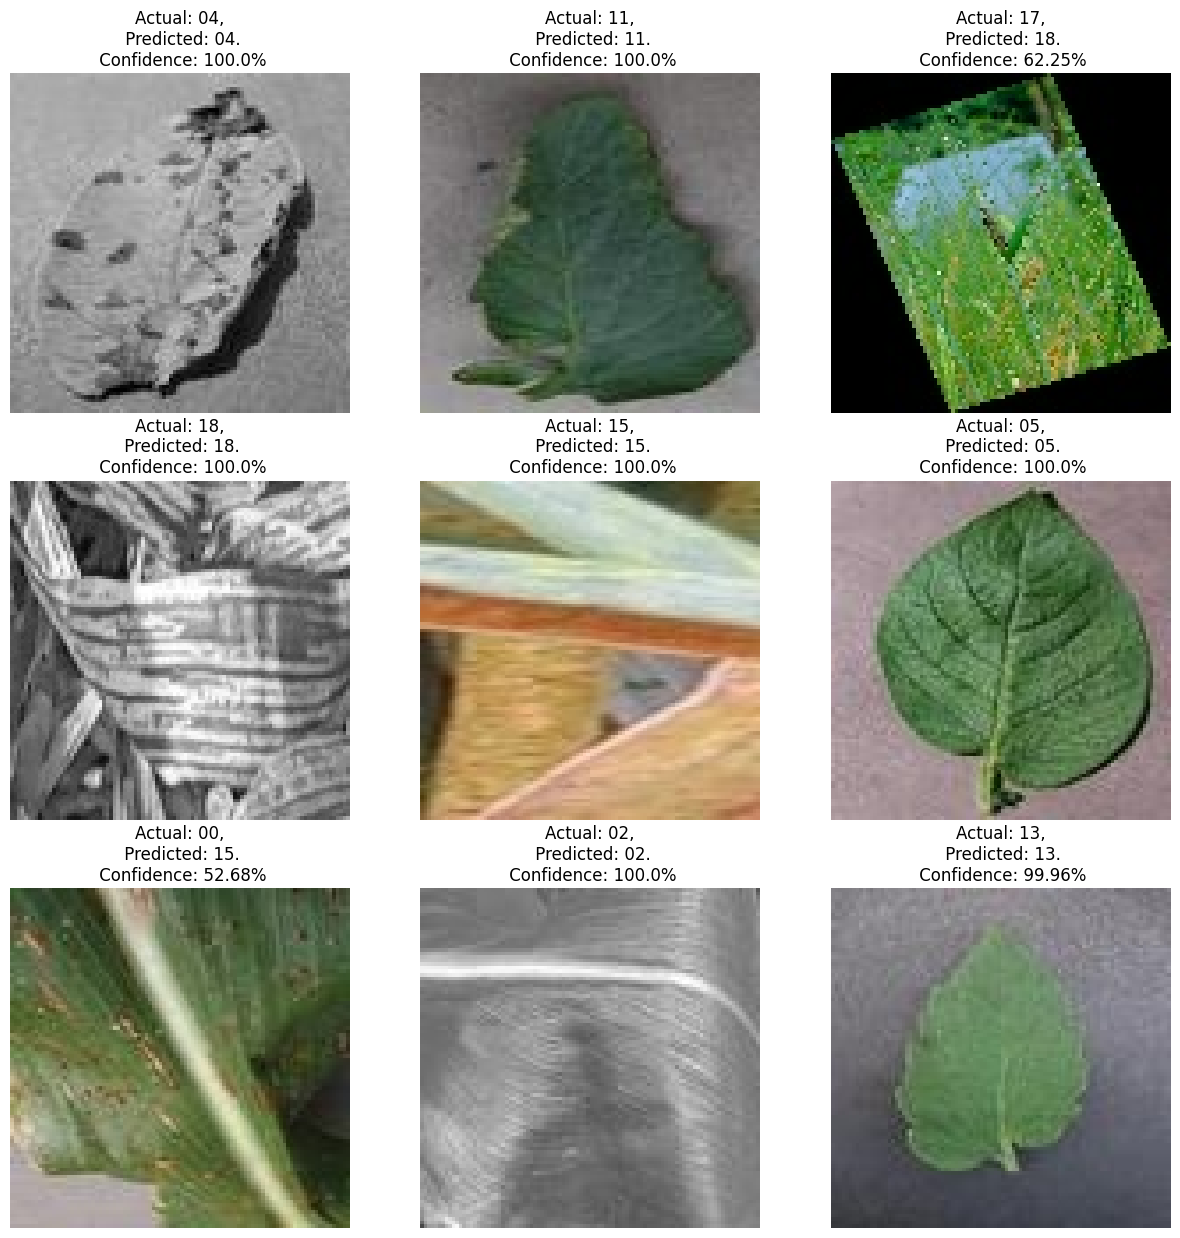

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

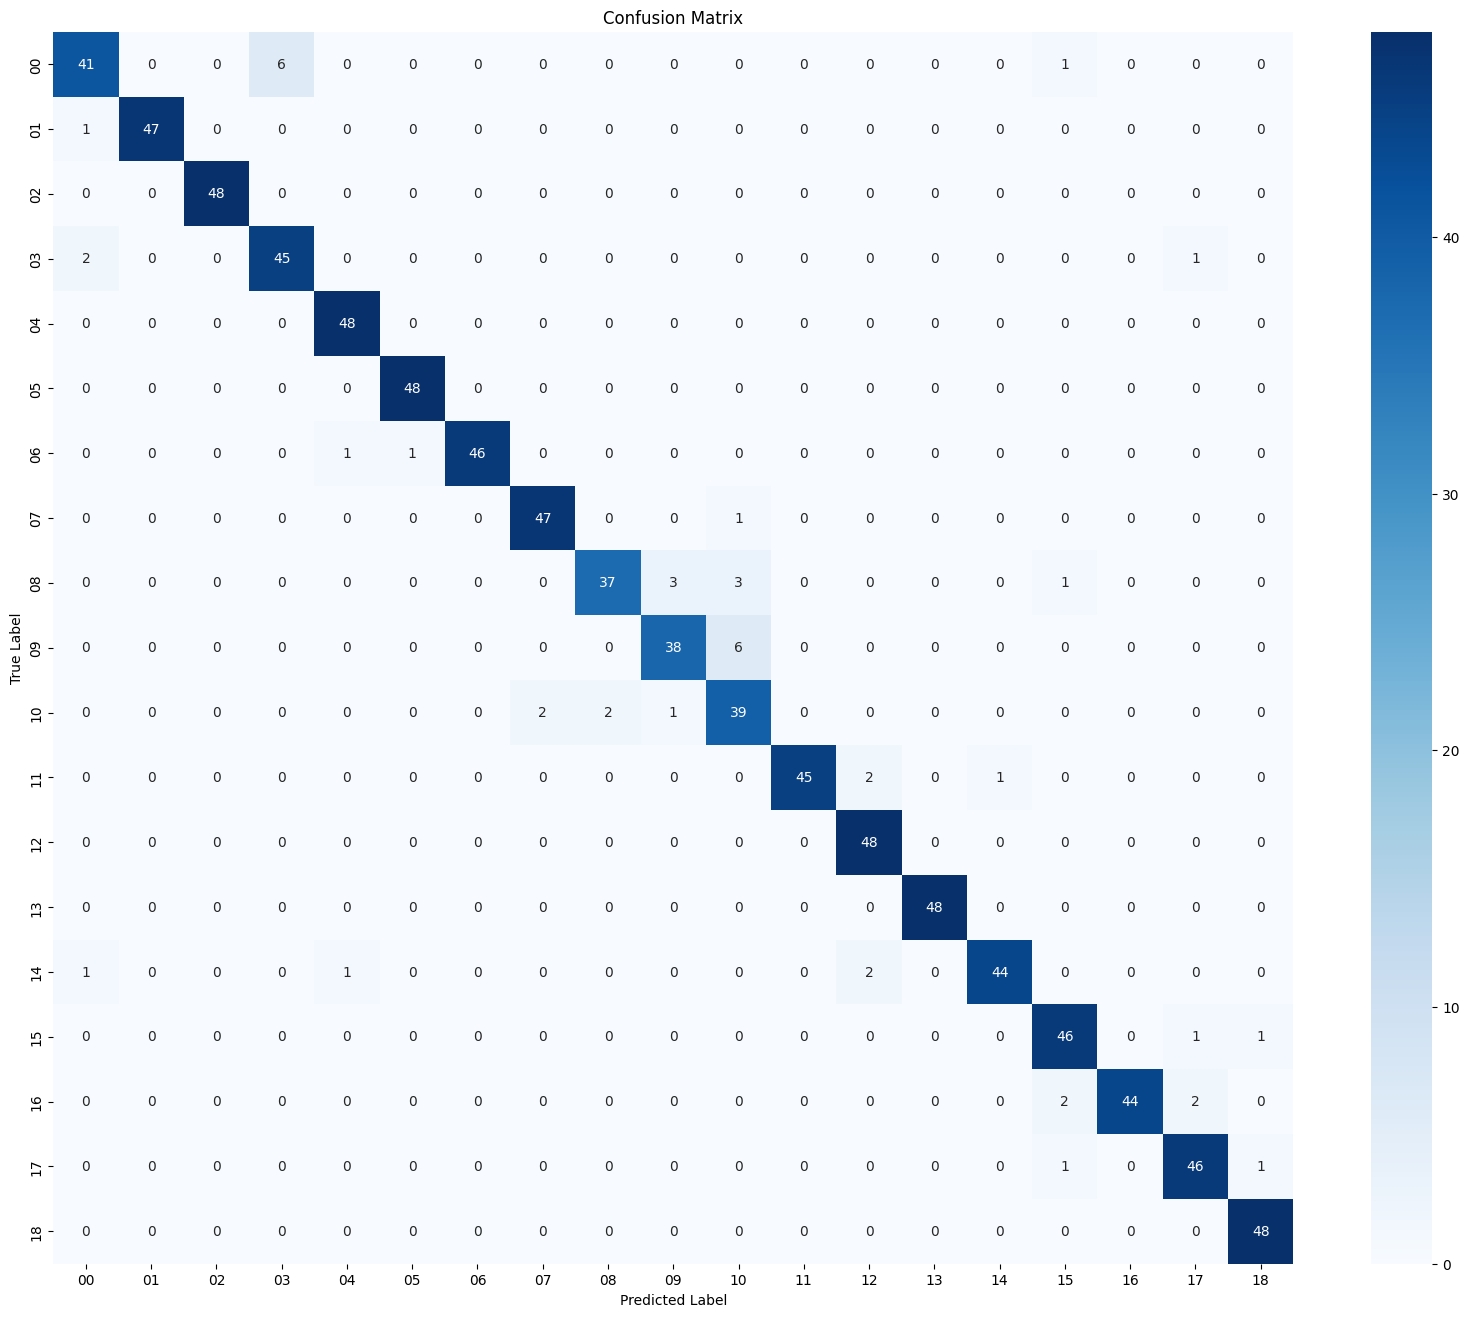

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

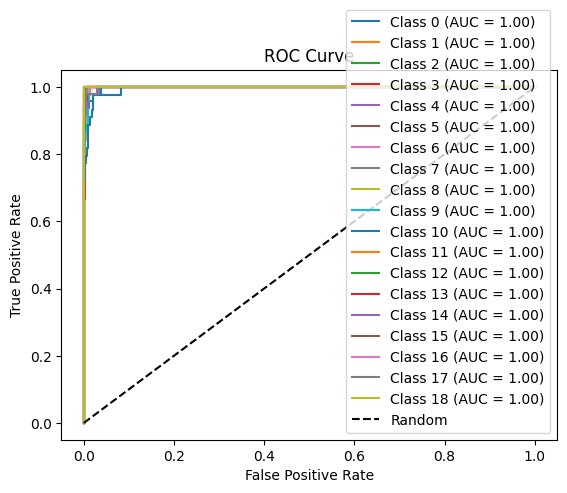

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
